<a href="https://colab.research.google.com/github/voke-brume/AI-ML/blob/main/ML/SqueezeNet1_0ForCIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CPE 620: DEEP LEARNING**
**Assignment 01**

Voke Brume

**SQUEEZENET FOR CIFAR-10 DATASET**

In [ ]:
# Import required libraries
import os
import torch

import numpy as np 
import seaborn as sns 
import torch.optim as optim
import torch.nn.init as init

from torch import nn 
from tabnanny import check
from sklearn.metrics import confusion_matrix
from torchvision import transforms, datasets

from matplotlib import pyplot as plt 

In [ ]:
# Confirm GPU is been used
if torch.cuda.is_available():
    print("Using the GPU. You are good to go!")
    device = torch.device('cuda:0')
else:
    raise Exception("WARNING: Could not find GPU! Using CPU only. \
To enable GPU, please to go Edit > Notebook Settings > Hardware \
Accelerator and select GPU.")

Using the GPU. You are good to go!


In [ ]:
# Initialize parameters
lr = 0.001
is_load = False   
is_save = True  
is_draw_conf = True    
num_epochs = 200
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0 
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

In [ ]:
# Fire Module
class Fire(nn.Module):
    def __init__(self, inplanes: int, squeeze_planes: int, expand1x1_planes: int, expand3x3_planes: int) -> None:
        super().__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes, kernel_size=1)
        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes, kernel_size=3, padding=1)
        self.expand3x3_activation = nn.ReLU(inplace=True)

    # Forward pass
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.squeeze_activation(self.squeeze(x))
        return torch.cat(
            [self.expand1x1_activation(self.expand1x1(x)), self.expand3x3_activation(self.expand3x3(x))], 1
        )

In [ ]:
# SqueezeNet1_0 (Figure 2. of prompt)
class SqueezeNet(nn.Module):
    def __init__(self, version: str = "1_0", num_classes: int = 10, dropout: float = 0.5) -> None:
        super().__init__()

        self.num_classes = num_classes
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=7, stride=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            Fire(96, 16, 64, 64),
            Fire(128, 16, 64, 64),
            Fire(128, 32, 128, 128),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            Fire(256, 32, 128, 128),
            Fire(256, 48, 192, 192),
            Fire(384, 48, 192, 192),
            Fire(384, 64, 256, 256),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            Fire(512, 64, 256, 256),
        )

        # Final convolution is initialized differently from the rest
        final_conv = nn.Conv2d(512, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout), final_conv, nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d((1, 1))
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv:
                    init.normal_(m.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    # Forward pass
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.classifier(x)
        return torch.flatten(x, 1)

In [ ]:
# Train module
class Train(nn.Module):

    def __init__(self):
        super().__init__()
        # Randomly crop CIFAR images to 32x32
        print('==> Preparing data..')
        self.transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])

        # Transform to tensor
        self.transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])

        # Load train data
        self.trainloader = torch.utils.data.DataLoader(
            datasets.CIFAR10(root='./data', train=True, download=True, transform=self.transform_train), 
            batch_size=256, 
            shuffle=True, 
            num_workers=6)

        # Load test data
        self.testloader = torch.utils.data.DataLoader(
            datasets.CIFAR10(root='./data', train=False, download=True, transform=self.transform_test), 
            batch_size=256, 
            shuffle=False, 
            num_workers=6)

        # Initialize all 10 classes
        self.classes = ('plane', 'car', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck')

        # Declare arrays to save accuracies
        self.ls_train_acc = []
        self.ls_test_acc = []

        # Build SqueezeNet1_0 Model
        print('==> Building model..')
        self.model = SqueezeNet(version="1_0")
        print(self.model)

        # Finetune for CIFAR
        self.model.classifier[1] = torch.nn.Conv2d(512, 10, kernel_size=(1, 1), stride=(1, 1))
        self.model = self.model.to(device)

        # Load checkpoint (Set to false until first save)
        if is_load:
            print('==> Resuming from checkpoint..')
            assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
            checkpoint = torch.load('./checkpoint/ckpt.pth')
            self.model.load_state_dict(checkpoint)

        # Use crossentropy loss and Adam optimizer
        self.criterion = torch.nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), 
                            lr=lr, 
                            betas=(0.9, 0.999), 
                            eps=1e-08,                      
                            weight_decay=5e-4)

        # Initialize optimizer and decays learning rate by gamma
        self.scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.90)



    # Training from scratch
    def train(self):
        self.model.train()
        for epoch in range(num_epochs):
            epoch = epoch + 1
            print('\nEpoch | %d/%d' % (epoch, num_epochs))
            train_loss = 0
            correct = 0
            total = 0
            for inputs, targets in self.trainloader:
                inputs, targets = inputs.to(device), targets.to(device)
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

            train_acc = 100.0 * (correct / total)
            print('Train Loss: %.3f | Acc: %.3f%%' % (train_loss, train_acc))
            if (epoch % 5 == 0 and epoch != 0):
                self.ls_train_acc.append(train_acc)

            self.test(epoch)

            if (epoch % 20 == 0 and epoch != 0):
                self.scheduler.step()

    # Test function 
    def test(self, epoch):
        global best_acc
        self.model.eval()
        test_loss = 0
        correct = 0
        total = 0

        true_label = []
        pred_label = []
        with torch.no_grad():
            for inputs, targets in self.testloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

                if is_draw_conf:
                    true_label += targets.cpu().detach().tolist()
                    pred_label += predicted.cpu().detach().tolist()

        test_acc = 100.0 * (correct / total)
        print('Test Loss: %.3f | Acc: %.3f%%' % (test_loss, test_acc))

        if (epoch % 5 == 0 and epoch != 0):
            self.ls_test_acc.append(test_acc)

        # Save checkpoint.
        if is_save:
            acc = 100.*correct/total
            if acc > best_acc:
                print('Saving..')
                if not os.path.isdir('checkpoint'):
                    os.mkdir('checkpoint')

                torch.save(self.model.state_dict(), './checkpoint/ckpt.pth')
                best_acc = acc

            # Switch is_load to True
            is_load = True

        self.model.train()
        if is_draw_conf: return true_label, pred_label


    def draw_confusion_matrix(self, true_labels, pred_labels):

        # make confusion matrix 
        c_matrix = confusion_matrix(y_true=true_labels, y_pred=pred_labels)
        c_matrix = [row / 10 for row in c_matrix]
        label = np.asarray([[str(col) + "%" for col in row] for row in c_matrix ])
        # setting the dimensions of the plot
        fig, c_matrix = plt.subplots(figsize=(20, 6))
        #sns.set(font_scale=1.4)
        fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
        sns.heatmap(ax=c_matrix, annot=label, annot_kws={'size': 0.2}, fmt = '.1f', linewidths=.5, xticklabels=self.classes, yticklabels=self.classes)

        # labels, title 
        plt.xlabel('Predicted Label', fontsize=10, labelpad=11)
        plt.ylabel('True Label', fontsize=10)
        plt.show()

In [ ]:
# Driver code to train and test
t = Train()
t.train()

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel

In [ ]:
# Save accuracies
np.save("train_acc.npy", t.ls_train_acc)
np.save("test_acc.npy", t.ls_test_acc)

In [ ]:
# Save accuracy values for train and test
ls_train_acc = (np.load("train_acc.npy")).tolist()
ls_test_acc = (np.load("test_acc.npy")).tolist()

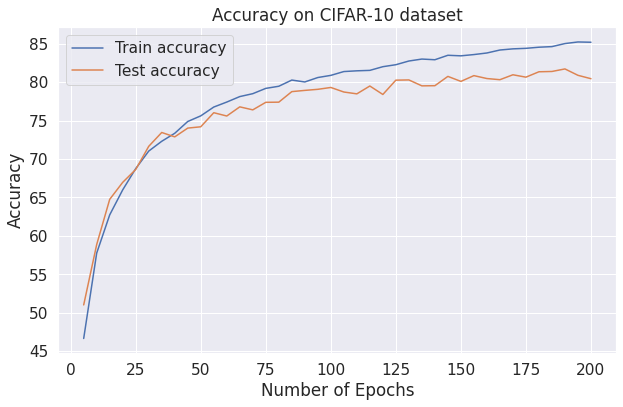

In [ ]:
# Plot ROC Curve
epochs = [i for i in range(5, 201, 5)]
plt.figure(figsize=(10,6))
plt.plot(epochs, ls_train_acc)
plt.plot(epochs, ls_test_acc)
plt.title('Accuracy on CIFAR-10 dataset')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train accuracy','Test accuracy'])
plt.show()

After about 50 epochs, ROC curve shows that training and testing accuracy keeps increasing, but model begins to overfit.

In [ ]:
# Values for computing confusion matrix
true_label, pred_label = t.test(epoch = 0)

Test Loss: 24.165 | Acc: 80.440%


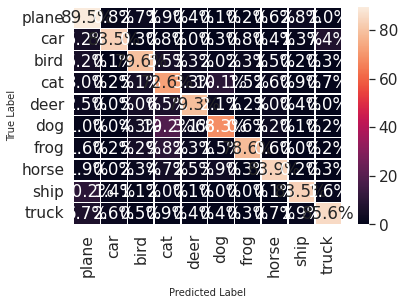

In [ ]:
# Confusion Matrix
t.draw_confusion_matrix(true_label, pred_label)